# Starbucks Capstone Challenge


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Data Overview

In [1]:
import os
import re
import pandas as pd
import numpy as np
import datetime
from joblib import dump, load
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



## Exploratory Data Analysis

#### 1 - Portfolio dataset

In [4]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [5]:
print('portfolio size  : {}'.format(portfolio.shape))
portfolio.head()

portfolio size  : (10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [6]:
def rename_column_name(dataframe, old_column_name, new_column_name):
    column_names = dataframe.columns.values
    select_data = np.array([elem == old_column_name for elem in column_names])
    column_names[select_data] = new_column_name
    return column_names

In [7]:
# Data Cleaning
def clean_portfolio(portfolio):
    """Clean the portfolio dataset."""
    cleaned_portfolio = portfolio.copy()
    # Change the name of the 'id' column to 'offerid'
    cleaned_portfolio.columns = rename_column_name(portfolio, 'id', 'offerid')
    cleaned_portfolio.columns = rename_column_name(portfolio, 'duration', 'durationdays')
    # Hot encoding channels to multiple columns
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    # Hot encoding offer_type to multiple columns
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    # drop the channels and offer_type column
    cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    # Combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    return cleaned_portfolio

In [8]:
# Portfolio dataset after Data Cleaning
cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio.head()

,reward,difficulty,durationdays,offerid,web,email,mobile,social,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


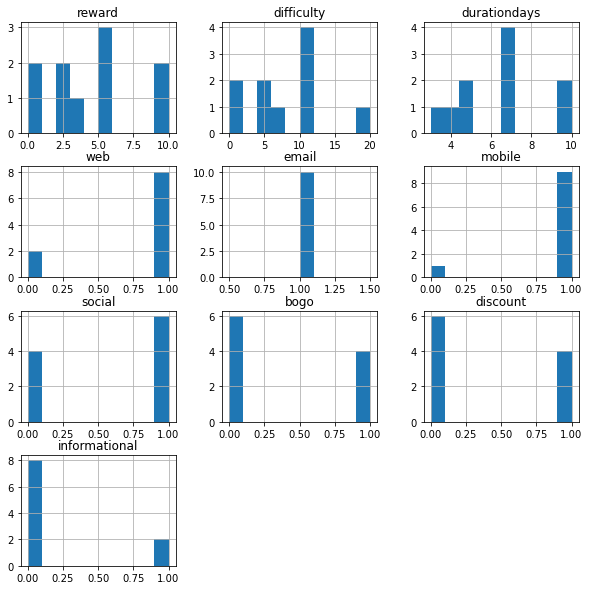

In [9]:
# Create a histogram of all features to show the distribution of each one relative to the data. 
cleaned_portfolio.hist(figsize=(10,10),xrot=0);

#### 2 - Profile dataset
Dataset containing demographic data for our users.

In [10]:
# # Profile dataset before cleaning
print('profile size  : {}'.format(profile.shape))
profile.head()

profile size  : (17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


* Data Exploration

In [11]:
print("Number of Rows", profile.shape[0])
print("Number of missing income",profile['income'].isna().sum() )
print("Number of missing gender",profile['gender'].isna().sum() )
print("Number of missing age", (profile['age'] == 118).sum() )

display(pd.DataFrame(profile.gender.value_counts()).T.style.set_caption('Gender by user'))


Number of Rows 17000
Number of missing income 2175
Number of missing gender 2175
Number of missing age 2175


,M,F,O
gender,8484,6129,212


In [12]:
print("Percentage of missing data: %.2f %%" % ((profile['age'] == 118).sum() / profile.shape[0] * 100))
profile.isnull().sum(axis=0) * 100 / profile.shape[0]

Percentage of missing data: 12.79 %


gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

In [13]:
gender_groups = profile.groupby(['gender']).count()
gender_counts = profile['gender'].value_counts()
gender_counts *= 100 / gender_counts.sum()
print('Count Groupby Gender \n', gender_groups)
print('Percentage of Gender (%) \n', gender_counts)

Count Groupby Gender 
          age    id  became_member_on  income
gender                                      
F       6129  6129              6129    6129
M       8484  8484              8484    8484
O        212   212               212     212
Percentage of Gender (%) 
 M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64


Since all the missing values are from the same rows. This could be due to the data quality issues from the web application where the income, gender and age are missing at the same time. 

We have decided to remove the following incomplete data as it is only about 13% of our cohort. This ensure the overall quality of our data rather than interpolating the data from the mean value.
* 12.79% Data with Missing `Gender`, `Income` and `Age` (coded as 118 treated as NaN)
* 1.43 % of Gender is coded as `O` which are undetermined



In [14]:
profile[profile['income'].notnull()].describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [15]:
# Profile cleaning function 
def clean_profile(profile):
    """Clean the profile dataset."""
    cleaned_profile = profile.copy()
    # Convert to datetime
    cleaned_profile.became_member_on = pd.to_datetime(cleaned_profile.became_member_on, format = '%Y%m%d')
    # age: (numeric) Convert value encoded as 118 to null
    cleaned_profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    # drop all missing values
    cleaned_profile.dropna(inplace=True)
    # drop Undetermined gender = O
    cleaned_profile = cleaned_profile[profile['gender'] != 'O']
    cleaned_profile = cleaned_profile.reset_index(drop=True)
    # hot encoding gender to multiple columns
    cleaned_profile['gendernew'] = cleaned_profile['gender'].apply(lambda x: 0 if 'M' in x else (1 if 'F' in x else x) )
    # the number of days since the user is a members of starbucks
    cleaned_profile['member_days'] = datetime.datetime.today().date() - pd.to_datetime(cleaned_profile['became_member_on'], format='%Y%m%d').dt.date
    cleaned_profile['member_days'] = cleaned_profile['member_days'].dt.days
    # drop the gender and offer_type column
    cleaned_profile.drop(['gender'], axis=1, inplace=True)
    cleaned_profile.drop(['became_member_on'], axis=1, inplace=True)
    # rename gendernew to gender
    cleaned_profile.columns = rename_column_name(cleaned_profile, 'gendernew', 'gender')
    # rename id to customerid
    cleaned_profile.columns = rename_column_name(cleaned_profile, 'id', 'customerid')
    return cleaned_profile

In [16]:
cleaned_profile = clean_profile(profile)
cleaned_profile.head()

,age,customerid,income,gender,member_days
0,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,1,1651
1,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,1718
2,68.0,e2127556f4f64592b11af22de27a7932,70000.0,0,1366
3,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,0,1442
4,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1532


In [17]:
cleaned_profile.describe()

,age,income,gender,member_days
count,14613.000000,14613.000000,14613.000000,14613.000000
mean,54.393417,65435.707931,0.419421,1797.991035
std,17.400201,21633.524110,0.493481,419.681797
min,18.000000,30000.000000,0.000000,1275.000000
25%,42.000000,49000.000000,0.000000,1483.000000
50%,55.000000,64000.000000,0.000000,1633.000000
75%,66.000000,80000.000000,1.000000,2073.000000
max,101.000000,120000.000000,1.000000,3098.000000


In [18]:
cleaned_profile.median()

age               55.0
income         64000.0
gender             0.0
member_days     1633.0
dtype: float64

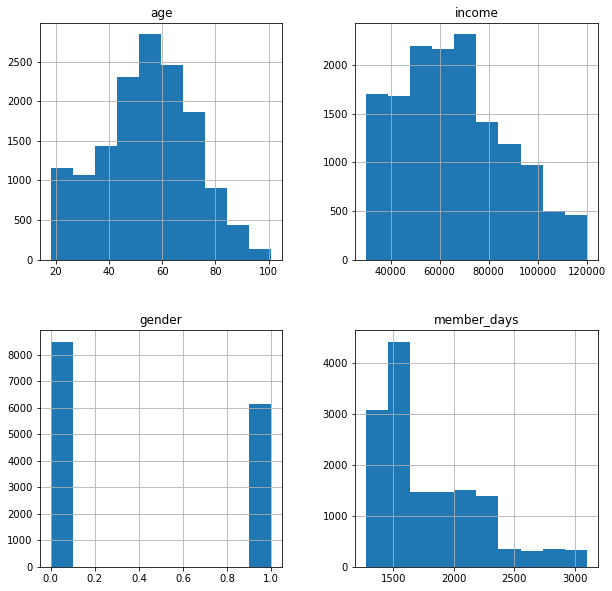

In [19]:
# Create a histogram of all features to show the distribution of each one relative to the data. 
cleaned_profile.hist(figsize=(10,10),xrot=0);

In [20]:
cleaned_profile.groupby('gender').describe()

age                                                      income  \
         count      mean        std   min   25%   50%   75%    max   count   
gender                                                                       
0       8484.0  52.11669  17.413894  18.0  39.0  53.0  65.0  100.0  8484.0   
1       6129.0  57.54495  16.883315  18.0  48.0  58.0  69.0  101.0  6129.0   

                      ...                    member_days               \
                mean  ...      75%       max       count         mean   
gender                ...                                               
0       61194.601603  ...  73000.0  120000.0      8484.0  1805.096535   
1       71306.412139  ...  88000.0  120000.0      6129.0  1788.155327   

                                                             
               std     min      25%     50%     75%     max  
gender                                                       
0       450.692976  1275.0  1467.75  1618.0  2094.0  3098.0  
1       372.331481  1275.0  1503.00  1675.0  2050.0  3097.0  

[2 rows x 24 columns]

* There is a large left skew on the `become member on` which indicate that the user population increased overtime. This also means that majority of the transaction occurs in the recent years. So we might need to remove this column
* Starbucks is slightly more popular with male.
* Male customer are also have higher income compared to female.
* Median values for income is 64000
* Median values for membership days is 1627

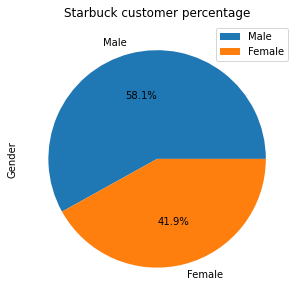

In [21]:
# Display Histogram of user gender
malesum = (cleaned_profile['gender'] == 0).sum()
femalesum = (cleaned_profile['gender'] == 1).sum()
gender_plot_data={
'LABEL':['Male', 'Female'],
'Gender':[malesum, femalesum]
}
fig, ax = plt.subplots(facecolor='lightslategray', figsize=(15, 5))
df = pd.DataFrame(data=gender_plot_data)
df.plot.pie( ax=ax, title="Starbuck customer percentage",y='Gender',labels=gender_plot_data['LABEL'], autopct='%1.1f%%')
fig.set_facecolor('white')

In [22]:
cleaned_profile_male = cleaned_profile[(cleaned_profile['gender'] == 0)]
cleaned_profile_female = cleaned_profile[(cleaned_profile['gender'] == 1)]


Text(0.5, 0, 'Female Income')

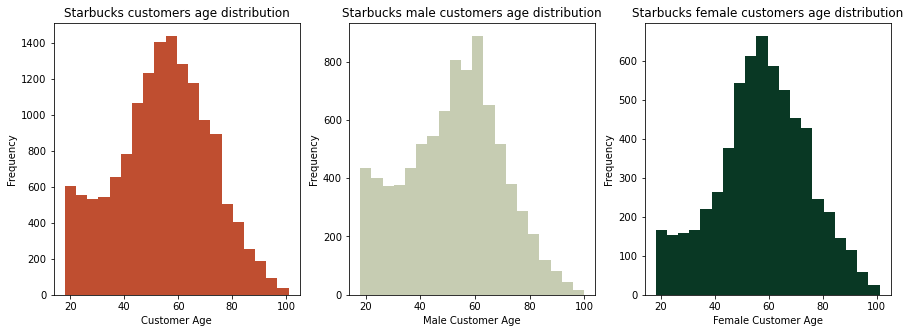

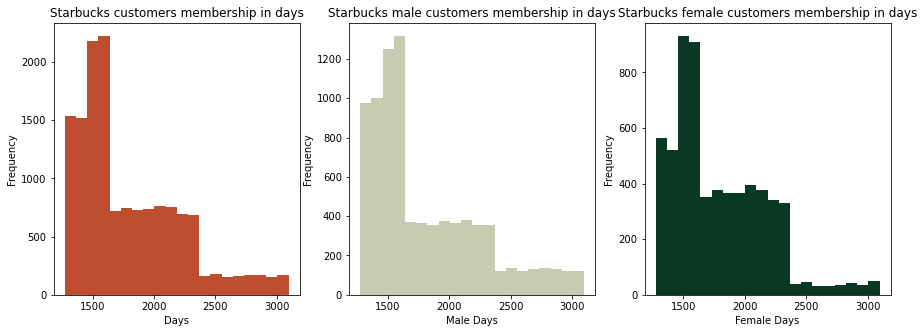

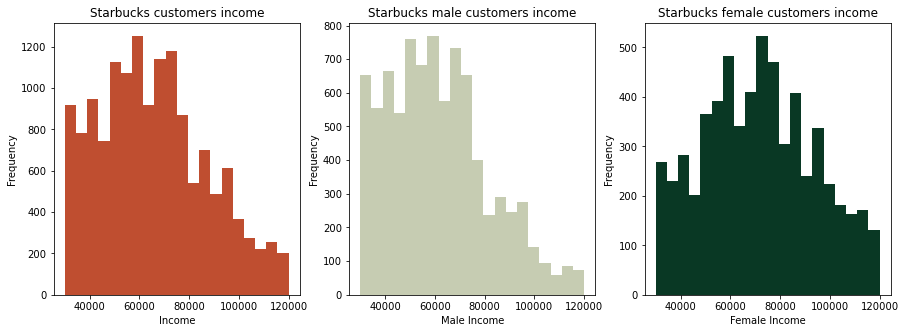

In [23]:
cleaned_profile_male = cleaned_profile[(cleaned_profile['gender'] == 0)]
cleaned_profile_female = cleaned_profile[(cleaned_profile['gender'] == 1)]

fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)
user_age_plot = cleaned_profile['age'].plot(ax=axes[0], kind='hist', bins=20,color ='#BF4E30', title='Starbucks customers age distribution')
user_age_plot.set_xlabel("Customer Age")
user_age_plot_male = cleaned_profile_male['age'].plot(ax=axes[1],kind='hist', bins=20,color ='#C6CCB2', title='Starbucks male customers age distribution')
user_age_plot_male.set_xlabel("Male Customer Age")
user_age_plot_female = cleaned_profile_female['age'].plot(ax=axes[2],kind='hist', bins=20,color ='#093824', title='Starbucks female customers age distribution')
user_age_plot_female.set_xlabel("Female Customer Age")

fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)
user_age_plot = cleaned_profile['member_days'].plot(ax=axes[0], kind='hist', bins=20,color ='#BF4E30', title='Starbucks customers membership in days')
user_age_plot.set_xlabel("Days")
user_age_plot_male = cleaned_profile_male['member_days'].plot(ax=axes[1],kind='hist', bins=20,color ='#C6CCB2', title='Starbucks male customers membership in days')
user_age_plot_male.set_xlabel("Male Days")
user_age_plot_female = cleaned_profile_female['member_days'].plot(ax=axes[2],kind='hist', bins=20,color ='#093824', title='Starbucks female customers membership in days')
user_age_plot_female.set_xlabel("Female Days")

fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)
user_age_plot = cleaned_profile['income'].plot(ax=axes[0], kind='hist', bins=20,color ='#BF4E30', title='Starbucks customers income')
user_age_plot.set_xlabel("Income")
user_age_plot_male = cleaned_profile_male['income'].plot(ax=axes[1],kind='hist', bins=20,color ='#C6CCB2', title='Starbucks male customers income')
user_age_plot_male.set_xlabel("Male Income")
user_age_plot_female = cleaned_profile_female['income'].plot(ax=axes[2],kind='hist', bins=20,color ='#093824', title='Starbucks female customers income')
user_age_plot_female.set_xlabel("Female Income")


#### 3 - Transcript Dataset
Output the first 5 rows of transaction records

In [24]:
print('transcript size  : {}'.format(transcript.shape))
transcript.head()

transcript size  : (306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Event Type Distribution

In [25]:
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)), columns=['event', 'count'])
event_counts

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


In [26]:
total_transactions = event_counts['count'].sum()
offer_received = (transcript['event'] == 'offer received').sum()
offer_viewed = (transcript['event'] == 'offer viewed').sum()
offer_completed = (transcript['event'] == 'offer completed').sum()
print('total_transactions', total_transactions)
print('offer_received', offer_received, "percentage: %.1f %%" % (offer_received/total_transactions * 100))
print('offer_viewed', offer_viewed, "percentage: %.1f %%" % (offer_received/total_transactions * 100))
print('offer_completed', offer_completed, "percentage: %.1f %%" % (offer_received/total_transactions * 100))
print()

total_transactions 306534
offer_received 76277 percentage: 24.9 %
offer_viewed 57725 percentage: 24.9 %
offer_completed 33579 percentage: 24.9 %



In [27]:
transcript.shape

(306534, 4)

In [28]:
transcript.head

<bound method NDFrame.head of                                   person           event  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received   
1       a03223e636434f42ac4c3df47e8bac43  offer received   
2       e2127556f4f64592b11af22de27a7932  offer received   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4       68617ca6246f4fbc85e91a2a49552598  offer received   
...                                  ...             ...   
306529  b3a1272bc9904337b331bf348c3e8c17     transaction   
306530  68213b08d99a4ae1b0dcb72aebd9aa35     transaction   
306531  a00058cf10334a308c68e7631c529907     transaction   
306532  76ddbd6576844afe811f1a3c0fbb5bec     transaction   
306533  c02b10e8752c4d8e9b73f918558531f7     transaction   

                                                   value  time  
0       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1       {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2       {'offer id': '2906b810c7d4411798c6938adc9daaa5

In [29]:
def process_and_clean_transcript(transcript, cleaned_profile):
    """Process and clean the transcript dataset."""
    transcript_cleaned = transcript   
    # Change the name of the 'person' column to 'customerid'
    transcript_cleaned.columns = rename_column_name(transcript_cleaned, 'person', 'customerid')
    # Remove customer id's that are not in the customer profile DataFrame
    customer_in_profile = transcript_cleaned['customerid'].isin(cleaned_profile['customerid'])
    transcript_cleaned = transcript_cleaned[customer_in_profile]
    transction_with_missing_customers = 100 * (1 - customer_in_profile.sum() / customer_in_profile.shape[0])
    print(" %.2f %%" % transction_with_missing_customers, "transactions with missing customers removed")

    # Convert from hours to days
    transcript_cleaned['time'] /= 24.0
    # Change the name of the time column to timedays
    transcript_cleaned.columns = rename_column_name(transcript_cleaned, 'time', 'timedays')

    is_offer = transcript['event'].str.contains('offer')

    # Transaction Dataset #
    transaction = transcript[is_offer == False]
    transaction = transaction.reset_index(drop=True)
    transaction['amount'] = transaction['value'].apply(lambda elem: list(elem.values())[0])
    transaction = transaction.drop(columns=['event', 'value'])
    transaction_column_order = ['customerid', 'timedays', 'amount']
    transaction = transaction[transaction_column_order]

    # Offer Dataset #
    offer_data = transcript_cleaned[is_offer].copy()
    offer_data = offer_data.reset_index(drop=True)
    # Create an offerid column
    offer_data['offerid'] = offer_data['value'].apply(lambda elem: list(elem.values())[0])

    # wrangling customer offer event data
    pattern_obj = re.compile('^offer ([a-z]+$)')
    transform_match_lambda = lambda elem: pattern_obj.match(elem).groups(1)[0]
    offer_data['event'] = offer_data['event'].apply(transform_match_lambda)
    # hot encode offer events
    event_df = pd.get_dummies(offer_data['event'])

    # offer events data
    offer_data = pd.concat([offer_data, event_df], axis=1)
    offer_data.drop(columns=['event', 'value'])
    offer_column_order = ['offerid', 'customerid', 'timedays']
    offer_column_order.extend(event_df.columns.values)
    offer_data = offer_data[offer_column_order]
    return transaction, offer_data

In [30]:
transaction_data, offer_data = process_and_clean_transcript(transcript, cleaned_profile)


 12.31 % transactions with missing customers removed


In [31]:
offer_data.head()

,offerid,customerid,timedays,completed,received,viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0


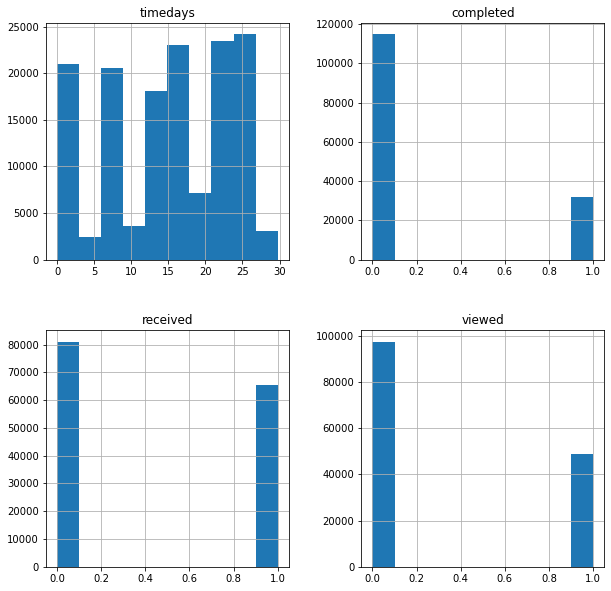

In [32]:
# Create a histogram of all features to show the distribution of each one relative to the data. 
offer_data.hist(figsize=(10,10),xrot=0);


In [33]:
cleaned_portfolio.head

<bound method NDFrame.head of    reward  difficulty  durationdays                           offerid  web  \
0      10          10             7  ae264e3637204a6fb9bb56bc8210ddfd    0   
1      10          10             5  4d5c57ea9a6940dd891ad53e9dbe8da0    1   
2       0           0             4  3f207df678b143eea3cee63160fa8bed    1   
3       5           5             7  9b98b8c7a33c4b65b9aebfe6a799e6d9    1   
4       5          20            10  0b1e1539f2cc45b7b9fa7c272da2e1d7    1   
5       3           7             7  2298d6c36e964ae4a3e7e9706d1fb8c2    1   
6       2          10            10  fafdcd668e3743c1bb461111dcafc2a4    1   
7       0           0             3  5a8bc65990b245e5a138643cd4eb9837    0   
8       5           5             5  f19421c1d4aa40978ebb69ca19b0e20d    1   
9       2          10             7  2906b810c7d4411798c6938adc9daaa5    1   

   email  mobile  social  bogo  discount  informational  
0      1       1       1     1         0             

In [34]:
transaction_data.shape

(138953, 3)

In [35]:
transaction_data.head()

,customerid,timedays,amount
0,02c083884c7d45b39cc68e1314fec56c,0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
2,54890f68699049c2a04d415abc25e717,0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [36]:
def get_valid_offer_rows(customer_id, portfolio, offer_data, transaction):
    """Process the customer transaction records and determine if an offer is success."""
    # offer data for a specific customer
    customer_offer_data = offer_data[offer_data['customerid'] == customer_id]
    customer_offer_data = customer_offer_data.reset_index(drop=True)

    offer_received = customer_offer_data[customer_offer_data['received'] == 1]
    offer_viewed = customer_offer_data[customer_offer_data['viewed'] == 1]
    offer_completed = customer_offer_data[customer_offer_data['completed'] == 1]
    offer_received = offer_received.reset_index(drop=True)
    offer_viewed = offer_viewed.reset_index(drop=True)
    offer_completed = offer_completed.reset_index(drop=True)

    # Transaction Data for current customer
    customer_transaction_data = transaction[transaction['customerid'] == customer_id]
    customer_transaction_data = customer_transaction_data.reset_index(
        drop=True)

    processed_customer_offers_rows = []
    for offer_received_index in range(offer_received.shape[0]):
        # current offer
        current_offer_id = offer_received.iloc[offer_received_index]['offerid']
        current_offer = portfolio.loc[portfolio['offerid'] == current_offer_id]
        durationdays = current_offer['durationdays'].values[0]

        # Valid Offer Time Period
        current_offer_startime = offer_received.iloc[offer_received_index]['timedays']
        current_offer_endtime = offer_received.iloc[offer_received_index]['timedays'] + durationdays

        # Valid Offer = Customer viewed the offer and completed the transaction within the duration window
        is_offer_completed = np.logical_and(offer_completed['timedays'] >= current_offer_startime, offer_completed['timedays'] <= current_offer_endtime)
        is_offer_viewed = np.logical_and(offer_viewed['timedays'] >= current_offer_startime, offer_viewed['timedays'] <= current_offer_endtime)
        is_offer_successful = is_offer_completed.sum() > 0 and is_offer_viewed.sum() > 0

        # Valid Transactions Due to Offer - Customer transactions within the current offer valid time window
        is_transaction_within_offer_period = np.logical_and(customer_transaction_data['timedays'] >= current_offer_startime,
                                                            customer_transaction_data['timedays'] <= current_offer_endtime)
        current_offer_transactions = customer_transaction_data[is_transaction_within_offer_period]

        processed_offer_row = {
            'offerid': current_offer_id,
            'customerid': customer_id,
            'offer_start_time': current_offer_startime,
            'offersuccessful': int(is_offer_successful),
            'totalamount': current_offer_transactions['amount'].sum(),
            'transactioncount': len(current_offer_transactions)
        }
        processed_customer_offers_rows.append(processed_offer_row)

    return processed_customer_offers_rows


In [37]:
def create_merged_dataset(cleaned_profile, cleaned_portfolio, offer_data, transaction_data):
    """Create the merged dataset."""
    merged_data = []
    customerid_list = offer_data['customerid'].unique()
    for customerindex in range(len(customerid_list)):
        #for idcustomerindexx in range(100):
        merged_data.extend(get_valid_offer_rows(customerid_list[customerindex],
                                                                 cleaned_portfolio,
                                                                 offer_data,
                                                                 transaction_data))

    merged_data = pd.DataFrame(merged_data)
    merged_data = merged_data.sort_values('offer_start_time')

    # merge portfolio
    merged_data = pd.merge(merged_data, cleaned_portfolio, on=[
                           "offerid", "offerid"], how='right')
    # merge profile
    merged_data = pd.merge(merged_data, cleaned_profile, on=[
                           "customerid", "customerid"], how='inner')
    
    merged_data = merged_data.reset_index(drop=True)
    return merged_data


In [38]:
def get_csv_cache(file_name):
    data_dir = "./data"
    merged_data_csvfile = os.path.join(data_dir, file_name)

    if os.path.exists(merged_data_csvfile):
        merged_data = pd.read_csv(merged_data_csvfile)
    else:
        merged_data = create_merged_dataset(cleaned_profile,
                                            cleaned_portfolio,
                                            offer_data,
                                            transaction_data)

        merged_data.to_csv(merged_data_csvfile, index=False)
    return merged_data


In [124]:
merged_data = get_csv_cache("merged_data.csv")

In [121]:
#dropping email because email was sent to everyone in the cohort.
#dropping member_days because member_days is not a good predictor.

merged_data = merged_data.drop(
    columns=['customerid', 'offer_start_time', 'email', 'member_days'])

column_ordering = ['offerid', 'totalamount', 'transactioncount']
column_ordering.extend(
    [elem for elem in merged_data.columns if elem not in column_ordering])

merged_data = merged_data[column_ordering]
merged_data.head()


,offerid,totalamount,transactioncount,offersuccessful,reward,difficulty,durationdays,web,mobile,social,bogo,discount,informational,age,income,gender
0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0,0,10,10,7,0,1,1,1,0,0,79.0,116000.0,1
1,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0,1,10,10,7,0,1,1,1,0,0,79.0,116000.0,1
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,0,5,20,10,1,0,0,0,1,0,79.0,116000.0,1
3,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,1,2,10,10,1,1,1,0,1,0,79.0,116000.0,1
4,2906b810c7d4411798c6938adc9daaa5,0.0,0,0,2,10,7,1,1,0,0,1,0,79.0,116000.0,1


In [122]:
totalamount_data = merged_data[["offerid", "totalamount"]]
totalamount_data.describe()


,totalamount
count,65585.000000
mean,1.045195
std,10.981303
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,962.100000


In [42]:
totalamount_data = merged_data[["offerid", "totalamount"]].groupby('offerid').sum()
print('Total Spend by offer \n', totalamount_data)

Total Spend by offer 
                                   totalamount
offerid                                      
0b1e1539f2cc45b7b9fa7c272da2e1d7      9491.04
2298d6c36e964ae4a3e7e9706d1fb8c2      7805.67
2906b810c7d4411798c6938adc9daaa5      9123.66
3f207df678b143eea3cee63160fa8bed      4339.46
4d5c57ea9a6940dd891ad53e9dbe8da0      6242.55
5a8bc65990b245e5a138643cd4eb9837      3093.08
9b98b8c7a33c4b65b9aebfe6a799e6d9      6793.07
ae264e3637204a6fb9bb56bc8210ddfd      7587.69
f19421c1d4aa40978ebb69ca19b0e20d      4947.76
fafdcd668e3743c1bb461111dcafc2a4      9125.12


# Analyse Offer Success Rate Profile

In [43]:
def analyse_offer_data_success_rate(portfolio, merged_data):
    """Analyse the offer data success rate and the total amount."""
    
    totaltransaction_count = merged_data[['offerid', 'transactioncount']].groupby('offerid').sum()
    totalamount_count = merged_data[['offerid', 'totalamount']].groupby('offerid').sum()
    successful_count = merged_data[['offerid', 'offersuccessful']].groupby('offerid').sum().reset_index()

    offer_count = merged_data['offerid'].value_counts()
    offer_count = pd.DataFrame(list(zip(offer_count.index.values, offer_count.values)), columns=['offerid', 'count'])

    successful_count = successful_count.sort_values('offerid')
    offer_count = offer_count.sort_values('offerid')
    totalamount_count = totalamount_count.sort_values('offerid')
    totaltransaction_count = totaltransaction_count.sort_values('offerid')

    offer_analysis = pd.merge(offer_count, successful_count, on="offerid")
    offer_analysis['success_rate'] = 100 * offer_analysis['offersuccessful'] / offer_analysis['count']
    offer_analysis = pd.merge(offer_analysis, totalamount_count, on="offerid")
    offer_analysis = pd.merge(offer_analysis, totaltransaction_count, on="offerid")
    offer_analysis = pd.merge(offer_analysis, portfolio, on="offerid")
    offer_analysis = offer_analysis.drop(columns=['offersuccessful'])
    offer_analysis = offer_analysis.sort_values('success_rate', ascending=False)
    return offer_analysis.reset_index(drop=True)

In [44]:
offer_analysis = analyse_offer_data_success_rate(cleaned_portfolio, merged_data)
offer_analysis

,offerid,count,success_rate,totalamount,transactioncount,reward,difficulty,durationdays,web,email,mobile,social,bogo,discount,informational
0,fafdcd668e3743c1bb461111dcafc2a4,6564,75.289458,9125.12,665,2,10,10,1,1,1,1,0,1,0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6563,72.741124,7805.67,566,3,7,7,1,1,1,1,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,6488,61.451911,4947.76,347,5,5,5,1,1,1,1,1,0,0
3,ae264e3637204a6fb9bb56bc8210ddfd,6590,54.522003,7587.69,501,10,10,7,0,1,1,1,1,0,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6521,51.602515,6242.55,393,10,10,5,1,1,1,1,1,0,0
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,6584,47.995140,6793.07,490,5,5,7,1,1,1,0,1,0,0
6,2906b810c7d4411798c6938adc9daaa5,6543,47.531713,9123.66,540,2,10,7,1,1,1,0,0,1,0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,6627,45.510789,9491.04,639,5,20,10,1,1,0,0,0,1,0
8,3f207df678b143eea3cee63160fa8bed,6561,7.742722,4339.46,287,0,0,4,1,1,1,0,0,0,1
9,5a8bc65990b245e5a138643cd4eb9837,6544,6.127751,3093.08,208,0,0,3,0,1,1,1,0,0,1


In [45]:
male_merged_data = merged_data[(merged_data['gender'] == 0)]
male_offer_analysis = analyse_offer_data_success_rate(cleaned_portfolio, male_merged_data)
male_offer_analysis

,offerid,count,success_rate,totalamount,transactioncount,reward,difficulty,durationdays,web,email,mobile,social,bogo,discount,informational
0,fafdcd668e3743c1bb461111dcafc2a4,3868,70.682523,4318.42,382,2,10,10,1,1,1,1,0,1,0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,3845,67.490247,4185.56,341,3,7,7,1,1,1,1,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,3767,56.251659,2376.00,185,5,5,5,1,1,1,1,1,0,0
3,ae264e3637204a6fb9bb56bc8210ddfd,3840,47.239583,3906.32,279,10,10,7,0,1,1,1,1,0,0
4,2906b810c7d4411798c6938adc9daaa5,3815,43.538663,3790.48,312,2,10,7,1,1,1,0,0,1,0
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,3817,43.280063,2882.37,272,5,5,7,1,1,1,0,1,0,0
6,4d5c57ea9a6940dd891ad53e9dbe8da0,3784,42.891121,3411.56,240,10,10,5,1,1,1,1,1,0,0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,3826,41.244119,3589.42,379,5,20,10,1,1,0,0,0,1,0
8,3f207df678b143eea3cee63160fa8bed,3812,7.030430,2572.88,171,0,0,4,1,1,1,0,0,0,1
9,5a8bc65990b245e5a138643cd4eb9837,3755,6.098535,1445.28,109,0,0,3,0,1,1,1,0,0,1


In [46]:
female_merged_data = merged_data[(merged_data['gender'] == 1)]
female_offer_analysis = analyse_offer_data_success_rate(cleaned_portfolio, female_merged_data)
female_offer_analysis

,offerid,count,success_rate,totalamount,transactioncount,reward,difficulty,durationdays,web,email,mobile,social,bogo,discount,informational
0,fafdcd668e3743c1bb461111dcafc2a4,2696,81.899110,4806.70,283,2,10,10,1,1,1,1,0,1,0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,2718,80.169242,3620.11,225,3,7,7,1,1,1,1,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,2721,68.651231,2571.76,162,5,5,5,1,1,1,1,1,0,0
3,ae264e3637204a6fb9bb56bc8210ddfd,2750,64.690909,3681.37,222,10,10,7,0,1,1,1,1,0,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,2737,63.646328,2830.99,153,10,10,5,1,1,1,1,1,0,0
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,2767,54.499458,3910.70,218,5,5,7,1,1,1,0,1,0,0
6,2906b810c7d4411798c6938adc9daaa5,2728,53.115836,5333.18,228,2,10,7,1,1,1,0,0,1,0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,2801,51.338808,5901.62,260,5,20,10,1,1,0,0,0,1,0
8,3f207df678b143eea3cee63160fa8bed,2749,8.730447,1766.58,116,0,0,4,1,1,1,0,0,0,1
9,5a8bc65990b245e5a138643cd4eb9837,2789,6.167085,1647.80,99,0,0,3,0,1,1,1,0,0,1


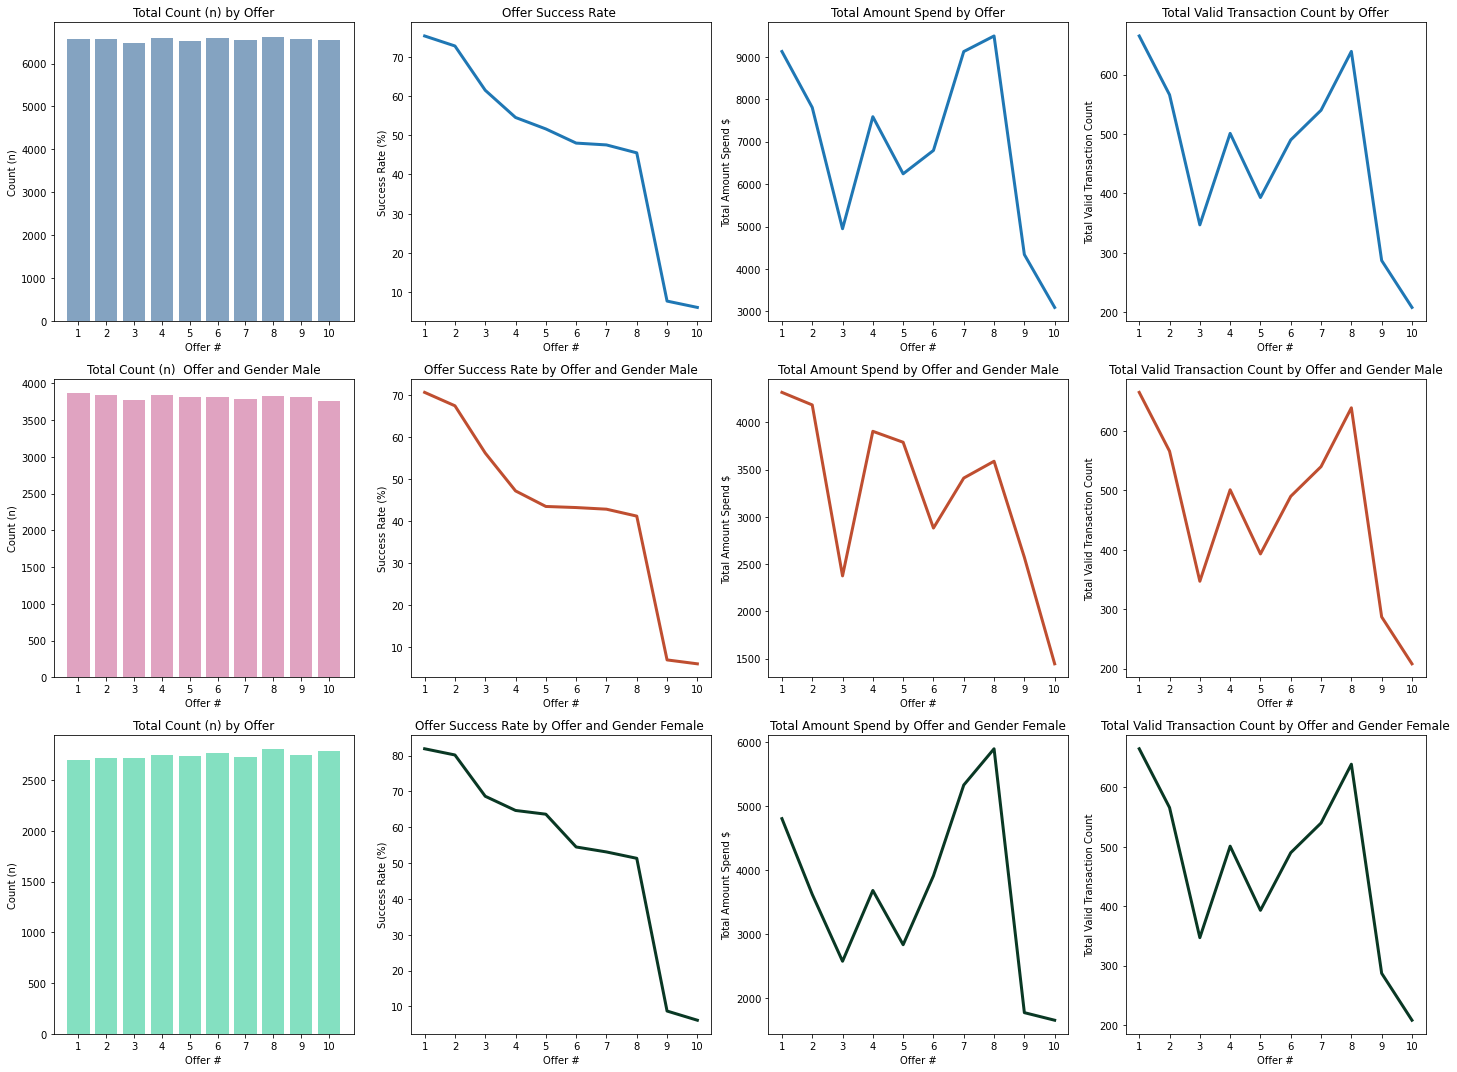

In [47]:
f, ax = plt.subplots(figsize=(20, 15),
                     nrows=3,
                     ncols=4)

ax[0, 0].bar(offer_analysis.index + 1, offer_analysis['count'],
             color=(0.2, 0.4, 0.6, 0.6))
ax[0, 0].set_xticks(np.arange(0, 10) + 1)
ax[0, 0].set_xlabel('Offer #')
ax[0, 0].set_ylabel('Count (n)')
ax[0, 0].title.set_text('Total Count (n) by Offer')

ax[0, 1].plot(offer_analysis.index + 1,
              offer_analysis['success_rate'],
              linewidth=3)
ax[0, 1].set_xticks(np.arange(0, 10) + 1)
ax[0, 1].set_xlabel('Offer #')
ax[0, 1].set_ylabel('Success Rate (%)')
ax[0, 1].title.set_text('Offer Success Rate ')

ax[0, 2].plot(offer_analysis.index + 1,
              offer_analysis['totalamount'],
              linewidth=3)
ax[0, 2].set_xticks(np.arange(0, 10) + 1)
ax[0, 2].set_xlabel('Offer #')
ax[0, 2].set_ylabel('Total Amount Spend $')
ax[0, 2].title.set_text('Total Amount Spend by Offer')

ax[0, 3].plot(offer_analysis.index + 1,
              offer_analysis['transactioncount'],
              linewidth=3)
ax[0, 3].set_xticks(np.arange(0, 10) + 1)
ax[0, 3].set_xlabel('Offer #')
ax[0, 3].set_ylabel('Total Valid Transaction Count')
ax[0, 3].title.set_text('Total Valid Transaction Count by Offer')

# male_success_rate
ax[1, 0].bar(male_offer_analysis.index + 1,
             male_offer_analysis['count'], color=(0.8, 0.4, 0.6, 0.6))
ax[1, 0].set_xticks(np.arange(0, 10) + 1)
ax[1, 0].set_xlabel('Offer #')
ax[1, 0].set_ylabel('Count (n)')
ax[1, 0].title.set_text('Total Count (n)  Offer and Gender Male')

ax[1, 1].plot(male_offer_analysis.index + 1,
              male_offer_analysis['success_rate'],
              linewidth=3,
              c='#BF4E30')
ax[1, 1].set_xticks(np.arange(0, 10) + 1)
ax[1, 1].set_xlabel('Offer #')
ax[1, 1].set_ylabel('Success Rate (%)')
ax[1, 1].title.set_text('Offer Success Rate by Offer and Gender Male')

ax[1, 2].plot(male_offer_analysis.index + 1,
              male_offer_analysis['totalamount'],
              linewidth=3,
              c='#BF4E30')
ax[1, 2].set_xticks(np.arange(0, 10) + 1)
ax[1, 2].set_xlabel('Offer #')
ax[1, 2].set_ylabel('Total Amount Spend $')
ax[1, 2].title.set_text('Total Amount Spend by Offer and Gender Male')

ax[1, 3].plot(offer_analysis.index + 1,
              offer_analysis['transactioncount'],
              linewidth=3,
              c='#BF4E30')
ax[1, 3].set_xticks(np.arange(0, 10) + 1)
ax[1, 3].set_xlabel('Offer #')
ax[1, 3].set_ylabel('Total Valid Transaction Count')
ax[1, 3].title.set_text(
    'Total Valid Transaction Count by Offer and Gender Male')

# female_success_rate
ax[2, 0].bar(female_offer_analysis.index + 1,
             female_offer_analysis['count'], color=(0.2, 0.8, 0.6, 0.6))
ax[2, 0].set_xticks(np.arange(0, 10) + 1)
ax[2, 0].set_xlabel('Offer #')
ax[2, 0].set_ylabel('Count (n)')
ax[2, 0].title.set_text('Total Count (n) by Offer')

ax[2, 1].plot(female_offer_analysis.index + 1,
              female_offer_analysis['success_rate'],
              linewidth=3,
              c='#093824')
ax[2, 1].set_xticks(np.arange(0, 10) + 1)
ax[2, 1].set_xlabel('Offer #')
ax[2, 1].set_ylabel('Success Rate (%)')
ax[2, 1].title.set_text('Offer Success Rate by Offer and Gender Female ')

ax[2, 2].plot(female_offer_analysis.index + 1,
              female_offer_analysis['totalamount'],
              linewidth=3,
              c='#093824')
ax[2, 2].set_xticks(np.arange(0, 10) + 1)
ax[2, 2].set_xlabel('Offer #')
ax[2, 2].set_ylabel('Total Amount Spend $')
ax[2, 2].title.set_text('Total Amount Spend by Offer and Gender Female')

ax[2, 3].plot(offer_analysis.index + 1,
              offer_analysis['transactioncount'],
              linewidth=3,
              c='#093824')
ax[2, 3].set_xticks(np.arange(0, 10) + 1)
ax[2, 3].set_xlabel('Offer #')
ax[2, 3].set_ylabel('Total Valid Transaction Count')
ax[2, 3].title.set_text(
    'Total Valid Transaction Count by Offer and Gender Female')


plt.tight_layout()


* While Offer number 1 have the highest success percentage, offer 7 and 8 return almost the same amount of spend as offer 1 despite only around 47% of success offer rate.
* Female respond very well for offer 7 and 8 while male respond well to offer 1 and 2
* Removing data that are not good for predicting the success of the offer
* There is a large left skew of the member_days which mean that it not a good predictor as majority of the transaction is occurs recently.
* offerid is a guid

# Prepare Merge Data for Splitting

In [ ]:
merged_data = merged_data.drop(columns=['offerid','totalamount', 'transactioncount'])
# convert all values to int
merged_data = merged_data.astype(int)

# Split Data

Training Models baseline model to be compared to XGBoost Model in SageMaker
* Logistic Regression Model
* Random Forest Model
* Gradient Boosting Classifier
* XGBoost in SageMaker

* `X_train` - This includes your all independent variables,these will be used to train the model, also as we have specified the test_size = 0.2, this means 80% of observations from your complete data will be used to train/fit the model and rest 20% will be used to test the model.
* `X_test` - This is remaining 40% portion of the independent variables from the data which will not be used in the training phase and will be used to make predictions to test the accuracy of the model.
* `y_train` - This is your dependent variable which needs to be predicted by this model, this includes category labels against your independent variables, we need to specify our dependent variable while training/fitting the model.
* `y_test` - This data has category labels for your test data, these labels will be used to test the accuracy between actual and predicted categories.

Based on validation split 
https://radiopaedia.org/articles/validation-split-machine-learning

60% training, 20% validation and 20% Testing Data


In [49]:

random_state = 1234

class_label_name = 'offersuccessful'

X = merged_data.drop(columns=[class_label_name])
y = merged_data.filter([class_label_name])

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=random_state)

X_train, X_val, y_train, Y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)


In [50]:
X

,reward,difficulty,durationdays,web,mobile,social,bogo,discount,informational,age,income,gender
0,10,10,7,0,1,1,1,0,0,79,116000,1
1,10,10,7,0,1,1,1,0,0,79,116000,1
2,5,20,10,1,0,0,0,1,0,79,116000,1
3,2,10,10,1,1,1,0,1,0,79,116000,1
4,2,10,7,1,1,0,0,1,0,79,116000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
65580,2,10,7,1,1,0,0,1,0,70,79000,1
65581,2,10,7,1,1,0,0,1,0,66,56000,0
65582,2,10,7,1,1,0,0,1,0,81,94000,1
65583,2,10,7,1,1,0,0,1,0,31,45000,0


In [51]:
X_train

,reward,difficulty,durationdays,web,mobile,social,bogo,discount,informational,age,income,gender
43343,2,10,7,1,1,0,0,1,0,60,92000,0
62426,0,0,3,0,1,1,0,0,1,55,83000,1
62456,2,10,10,1,1,1,0,1,0,70,35000,1
31614,10,10,5,1,1,1,1,0,0,73,59000,0
12031,3,7,7,1,1,1,0,1,0,49,97000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
26618,3,7,7,1,1,1,0,1,0,43,63000,0
45954,5,5,5,1,1,1,1,0,0,79,61000,1
50628,2,10,10,1,1,1,0,1,0,24,57000,0
2974,10,10,7,0,1,1,1,0,0,76,53000,1


# Modeling Section

In [2]:
def get_model_cache(model_file_name, create_model):
    """Get the model from cache if exist, if it does not, cache the model."""
    model_dir = "./models"
    model_path = os.path.join(model_dir, model_file_name)

    if os.path.exists(model_path):
        model = load(model_path)
    else:
        model = create_model()

        dump(model, model_path)
    return model


In [3]:
def print_model_performance(model, X_train, y_train):
    """Print Model Performance."""
    y_pred = model.predict(X_train)
    report = classification_report(y_train, y_pred)
    print('report:', report, sep='\n')
    model_accuracy = accuracy_score(y_train, y_pred)
    model_f1_score = f1_score(y_train, y_pred)

    print("model accuracy: %.3f" % (model_accuracy))
    print("model f1-score: %.3f" % (model_f1_score))


def get_model_performance_score(model, X_train, y_train):
    """Return accuracy score and f1 score."""
    y_pred = model.predict(X_train)
    model_accuracy = accuracy_score(y_train, y_pred)
    model_f1_score = f1_score(y_train, y_pred)
    return model_accuracy, model_f1_score


### 1) Logistic Regression Model

We utilized RandomizedSearchCV here instead of GridSearchCV as RandomizedSearchCv give a randomized approach give the closest possible accurate estimator while saving on computational cost instead of running every single combination possible.

In [13]:
def create_model_lr():
    random_state = 1234
    LR_offer = LogisticRegression(
        solver='liblinear', C=10.0, random_state=random_state)
    LR_offer.fit(X_train, y_train)
    LR_offer.score(X_train, y_train)
    return LR_offer

In [14]:
lr_initial_model = get_model_cache("lr_initial_model.sav", create_model_lr)

In [15]:
print_model_performance(lr_initial_model, X_train, y_train)

report:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70     20801
           1       0.66      0.74      0.70     18550

    accuracy                           0.70     39351
   macro avg       0.70      0.70      0.70     39351
weighted avg       0.70      0.70      0.70     39351

model accuracy: 0.699
model f1-score: 0.698


#### Performing Randomized Search cross validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [16]:
def create_model_lr_randomized_search_cv():
    random_state = 1234
    LR_offer = LogisticRegression(
        solver='liblinear', C=10.0, random_state=random_state)
    random_grid = {'penalty': ['l1', 'l2'],
                   'C': [1.0, 0.1, 0.01]}
    scorer = make_scorer(fbeta_score, beta=0.5)
    # train the random search meta-estimator to find the best model out of 6 candidates
    # this will train 6 models over 3 folds of cross validation (18 models total)
    lr_randomized_search_cv = RandomizedSearchCV(estimator=LR_offer,
                                                 param_distributions=random_grid,
                                                 scoring=scorer,
                                                 n_iter=6,
                                                 cv=3,
                                                 verbose=2,
                                                 n_jobs=3,
                                                 random_state=random_state)
    lr_randomized_search_cv.fit(X_train, y_train)
    lr_randomized_search_cv.score(X_train, y_train)
    return lr_randomized_search_cv


In [17]:
lr_randomized_search_cv = get_model_cache("lr_model.sav", create_model_lr_randomized_search_cv)

Evaluate Model Performance

In [18]:
print_model_performance(lr_randomized_search_cv.best_estimator_, X_train, y_train)

report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70     20801
           1       0.66      0.73      0.69     18550

    accuracy                           0.70     39351
   macro avg       0.70      0.70      0.70     39351
weighted avg       0.70      0.70      0.70     39351

model accuracy: 0.698
model f1-score: 0.694


### 2) Random Forest Model


In [20]:
def create_model_rf_initial_model():
    random_state = 1234
    rf_classifier = RandomForestClassifier(n_estimators=3,max_depth=5,min_samples_leaf=2,random_state=random_state)
    
    rf_classifier.fit(X_train, y_train)
    return rf_classifier


In [21]:
rf_initial_model = get_model_cache("rf_initial_model.sav", create_model_rf_initial_model)

In [22]:
print_model_performance(rf_initial_model, X_train, y_train)

report:
              precision    recall  f1-score   support

           0       0.79      0.59      0.67     20801
           1       0.64      0.82      0.72     18550

    accuracy                           0.70     39351
   macro avg       0.71      0.71      0.70     39351
weighted avg       0.72      0.70      0.70     39351

model accuracy: 0.699
model f1-score: 0.721


#### Performing Randomized Search cross validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [23]:
def create_model_rf_randomized_search_cv():
    random_state = 1234
    rf_classifier = RandomForestClassifier(random_state=random_state)
    # Number of trees in random forest
    n_estimators = [10, 30, 50, 100, 150, 200, 250, 300]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [8,9,10,11,12]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    parameter = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf}
    scorer = make_scorer(fbeta_score, beta=0.5)
    # train the random search meta-estimator to find the best model out of 100 candidates
    # this will train 100 models over 3 folds of cross validation (300 models total)
    rf_randomized_search_cv = RandomizedSearchCV(estimator=rf_classifier,
                                                 param_distributions=parameter,
                                                 scoring=scorer,
                                                 n_iter=100,
                                                 cv=3,
                                                 verbose=2,
                                                 n_jobs=3,
                                                 random_state=random_state)
    rf_randomized_search_cv.fit(X_train, y_train)
    return rf_randomized_search_cv


In [24]:
rf_randomized_search_cv = get_model_cache("rf_model.sav", create_model_rf_randomized_search_cv)

In [25]:
print_model_performance(rf_randomized_search_cv.best_estimator_, X_train, y_train)

report:
              precision    recall  f1-score   support

           0       0.79      0.65      0.72     20801
           1       0.67      0.81      0.73     18550

    accuracy                           0.73     39351
   macro avg       0.73      0.73      0.73     39351
weighted avg       0.74      0.73      0.72     39351

model accuracy: 0.725
model f1-score: 0.735


### Feature Importance

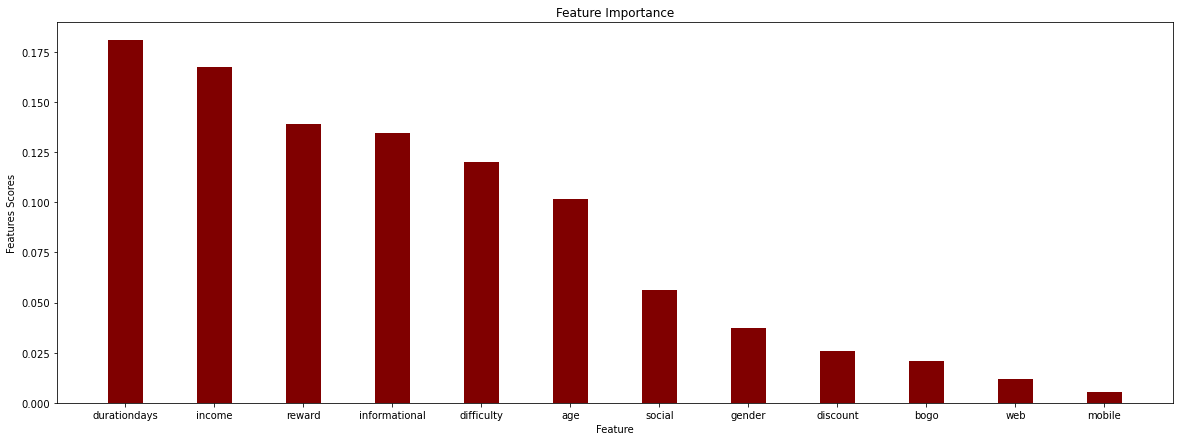

In [60]:
relative_importance = rf_randomized_search_cv.best_estimator_.feature_importances_
feature_importance = pd.DataFrame(list(zip(X, relative_importance)), columns=['feature', 'relativeimportance'])
feature_importance = feature_importance.sort_values('relativeimportance', ascending=False)
feature_importance = feature_importance.reset_index(drop=True)
 
fig = plt.figure(figsize = (20, 7))
 
# creating the bar plot
plt.bar(feature_importance['feature'], feature_importance['relativeimportance'], color ='maroon', width = 0.4)
 
plt.xlabel("Feature")
plt.ylabel("Features Scores")
plt.title("Feature Importance")
plt.show()

In [61]:
feature_importance

,feature,relativeimportance
0,durationdays,0.180678
1,income,0.167380
2,reward,0.138796
3,informational,0.134509
4,difficulty,0.119955
5,age,0.101562
6,social,0.056204
7,gender,0.037193
8,discount,0.025943
9,bogo,0.020659


# Model Results

In [26]:
model_performance_results = []

classifier_type = ['Logistic Regression', 'Random Forest']

model_performance_results.append(get_model_performance_score(lr_randomized_search_cv.best_estimator_, X_train, y_train))
model_performance_results.append(get_model_performance_score(rf_randomized_search_cv.best_estimator_, X_train, y_train))

model_performance_results = pd.DataFrame(model_performance_results, columns=['Accuracy', 'F1Score'])
classifier_type = pd.DataFrame(classifier_type, columns=['Classifier Type'])
model_performance_results = pd.concat([classifier_type, model_performance_results], axis=1)
model_performance_results = model_performance_results.sort_values('Accuracy', ascending=False)
model_performance_results = model_performance_results.reset_index(drop=True)
model_performance_results

,Classifier Type,Accuracy,F1Score
0,Random Forest,0.725496,0.734673
1,Logistic Regression,0.698254,0.694206


In [28]:
print(rf_randomized_search_cv.best_estimator_)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       random_state=1234)


In [29]:
rf_randomized_search_cv.best_estimator_.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

# Cross validation and parameter tuning
We utilized RandomizedSearchCV here instead of GridSearchCV as RandomizedSearchCv give a randomized approach give the closest possible accurate estimator while saving on computational cost instead of running every single combination possible.
We tried other subset of parameter and see if we can get a better score here.

In [30]:
def create_model_rf_randomized_search_cv_tuning():
    """Model Tuning."""
    random_state = 1234
    rf_clf = RandomForestClassifier(random_state=random_state)
    # Number of trees in random forest
    n_estimators = [240, 250, 260, 280, 300, 400]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [8, 9, 10, 11, 12, 13]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # parameter
    parameter = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf}
    scorer = make_scorer(fbeta_score, beta=0.5)
    # train the random search meta-estimator to find the best model out of 100 candidates
    # this will train 100 models over 3 folds of cross validation (300 models total)
    rf_randomized_search_cv_tuning = RandomizedSearchCV(estimator=rf_clf,
                                                        param_distributions=parameter,
                                                        scoring=scorer,
                                                        n_iter=100,
                                                        cv=3,
                                                        verbose=2,
                                                        n_jobs=3,
                                                        random_state=random_state)
    rf_randomized_search_cv_tuning.fit(X_train, y_train)
    return rf_randomized_search_cv_tuning


In [31]:
best_model = get_model_cache("rf_tune_best_model.sav", create_model_rf_randomized_search_cv_tuning)

In [32]:
best_model.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=260,
                       random_state=1234)

In [33]:
print_model_performance(best_model,X_train, y_train)

report:
              precision    recall  f1-score   support

           0       0.79      0.66      0.72     20801
           1       0.68      0.81      0.74     18550

    accuracy                           0.73     39351
   macro avg       0.73      0.73      0.73     39351
weighted avg       0.74      0.73      0.73     39351

model accuracy: 0.728
model f1-score: 0.736


Load Merge Data for SageMaker

In [2]:
def get_csv_cache(file_name):
    data_dir = "./data"
    merged_data_csvfile = os.path.join(data_dir, file_name)

    if os.path.exists(merged_data_csvfile):
        merged_data = pd.read_csv(merged_data_csvfile)
    else:
        merged_data = create_merged_dataset(cleaned_profile,
                                            cleaned_portfolio,
                                            offer_data,
                                            transaction_data)

        merged_data.to_csv(merged_data_csvfile, index=False)
    return merged_data


In [3]:
merged_data = get_csv_cache("merged_data.csv")

In [4]:

#dropping email because email was sent to everyone in the cohort.
#dropping member_days because member_days is not a good predictor.
merged_data = merged_data.drop(
    columns=['offerid', 'customerid', 'offer_start_time', 'email', 'member_days', 'totalamount', 'transactioncount'])

merged_data

,offersuccessful,reward,difficulty,durationdays,web,mobile,social,bogo,discount,informational,age,income,gender
0,0,10,10,7,0,1,1,1,0,0,79.0,116000.0,1
1,1,10,10,7,0,1,1,1,0,0,79.0,116000.0,1
2,0,5,20,10,1,0,0,0,1,0,79.0,116000.0,1
3,1,2,10,10,1,1,1,0,1,0,79.0,116000.0,1
4,0,2,10,7,1,1,0,0,1,0,79.0,116000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65580,0,2,10,7,1,1,0,0,1,0,70.0,79000.0,1
65581,0,2,10,7,1,1,0,0,1,0,66.0,56000.0,0
65582,0,2,10,7,1,1,0,0,1,0,81.0,94000.0,1
65583,1,2,10,7,1,1,0,0,1,0,31.0,45000.0,0


In [5]:
merged_data = merged_data.astype(int)
merged_data.head()

,offersuccessful,reward,difficulty,durationdays,web,mobile,social,bogo,discount,informational,age,income,gender
0,0,10,10,7,0,1,1,1,0,0,79,116000,1
1,1,10,10,7,0,1,1,1,0,0,79,116000,1
2,0,5,20,10,1,0,0,0,1,0,79,116000,1
3,1,2,10,10,1,1,1,0,1,0,79,116000,1
4,0,2,10,7,1,1,0,0,1,0,79,116000,1


In [6]:
# 60% training, 20% cross validation and 20% Test data
random_state = 1234

class_label_name = 'offersuccessful'

X = merged_data.drop(columns=[class_label_name])
y = merged_data.filter([class_label_name])

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=random_state)

X_train, X_val, y_train, Y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)


# 3) Amazon Sage maker XG-Boost built in Algorithm

XGBoost
References 
https://github.com/udacity/sagemaker-deployment/blob/master/Tutorials/Boston%20Housing%20-%20XGBoost%20(Batch%20Transform)%20-%20High%20Level.ipynb

In [7]:
pip install -U sagemaker

     |████████████████████████████████| 481 kB 23.3 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker: filename=sagemaker-2.73.0-py2.py3-none-any.whl size=662723 sha256=932f211ed5c14fd5da0aaaf8b45508520c4e69506def223cb50912069821b414
  Stored in directory: /home/ec2-user/.cache/pip/wheels/18/dd/89/bfdf02e6fa6179e9c2e70cb1df9300de4faea02d6de273ae73
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.72.1
    Uninstalling sagemaker-2.72.1:
      Successfully uninstalled sagemaker-2.72.1
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
import os

In [9]:

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.serializers import CSVSerializer

In [10]:
# Sagemaker session
session = sagemaker.Session()

# IAM role
role = get_execution_role()
# current bucket
bucket = session.default_bucket()

### Uploading the data files to S3

In [11]:
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)


We do not include header and index when saving to as this is Amazon requirement
For the train and validation data, it is assumed that the first entry in each row is the target variable.

In [12]:

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)
pd.concat([y_test, X_test], axis=1).to_csv(os.path.join(data_dir, 'testfulldata.csv'), header=False, index=False)
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

In [13]:
prefix = 'xgboost-starbucks'

testfulldata_location = session.upload_data(os.path.join(data_dir, 'testfulldata.csv'), key_prefix=prefix)
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [14]:
print('Training data is stored in: '+ train_location)
print('Validation data is stored in: '+ val_location)
print('Test data is stored in: '+ test_location)

Training data is stored in: s3://sagemaker-us-east-1-028910220072/xgboost-starbucks/train.csv
Validation data is stored in: s3://sagemaker-us-east-1-028910220072/xgboost-starbucks/validation.csv
Test data is stored in: s3://sagemaker-us-east-1-028910220072/xgboost-starbucks/test.csv


In [105]:
data_dir = 'data'
train_location = "s3://sagemaker-us-east-1-028910220072/xgboost-starbucks/train.csv"
val_location = "s3://sagemaker-us-east-1-028910220072/xgboost-starbucks/train.csv"
test_location = "s3://sagemaker-us-east-1-028910220072/xgboost-starbucks/test.csv"


### Train the XGBoost model
with hyperparameter tuning
* https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html
* https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html

* `Subsample` ratio of the training instance.
Setting it to 0.70 means that XGBoost randomly collects 70& of the data instances to grow trees.
This prevents overfitting. Default value: 1
* `Eta` Step size shrinkage, prevents overfitting.
* `Gamma` Minimum loss reduction to create a partition, larger = more conservative
* `Alpha` L1 regularization term; larger = more conservative
* `Lambda` L2 regularization term; larger = more conservative

In [16]:
# define the location of the Amazon SageMaker XGBoost training containers
region = boto3.Session().region_name  
container = sagemaker.image_uris.retrieve(
    region=region,
    framework="xgboost",
    version="latest"
)
# Create an Amazon SageMaker estimator
xgb = sagemaker.estimator.Estimator(container,  # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    instance_count=1,                  # How many compute instances
                                    instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    # Where to save the output (the model artifacts)
                                    output_path='s3://{}/{}/output'.format(
                                        session.default_bucket(), prefix),
                                    sagemaker_session=session)

# And then set the algorithm specific parameters.
xgb.set_hyperparameters(max_depth=30,
                        eta=0.02,
                        gamma=2.6,
                        min_child_weight=5,
                        subsample=0.70,
                        silent=0,
                        max_delta_step=3,
                        objective='binary:logistic',  # binary classification problem
                        early_stopping_rounds=30,
                        num_round=500)


In [17]:
#https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:auc', # The metric used to compare trained models.
                                               objective_type = 'Maximize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 30, # The total number of models to train
                                               max_parallel_jobs = 6, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(5,50),
                                                    'eta'      : ContinuousParameter(0.02, 0.4),
                                                    'min_child_weight': IntegerParameter(2, 5),
                                                    'num_round': IntegerParameter(400, 800),
                                                    'subsample': ContinuousParameter(0.60, 0.80),
                                                    'gamma': ContinuousParameter(0.5, 3.5),
                                               })

In [18]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

..........................................................................................................................................................................................................................!


In [19]:
xgb_hyperparameter_tuner.wait()

!


In [20]:
xgb_estimator_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())


2022-01-20 14:18:25 Starting - Preparing the instances for training
2022-01-20 14:18:25 Downloading - Downloading input data
2022-01-20 14:18:25 Training - Training image download completed. Training in progress.
2022-01-20 14:18:25 Uploading - Uploading generated training model
2022-01-20 14:18:25 Completed - Training job completed


In [21]:
xgb_hyperparameter_tuner.best_training_job()

'xgboost-220120-1408-005-28b42f21'

In [22]:
xgb_hyperparameter_tuner.hyperparameter_ranges()

{'ContinuousParameterRanges': [{'Name': 'eta',
   'MinValue': '0.02',
   'MaxValue': '0.04',
   'ScalingType': 'Auto'},
  {'Name': 'subsample',
   'MinValue': '0.7',
   'MaxValue': '0.73',
   'ScalingType': 'Auto'},
  {'Name': 'gamma',
   'MinValue': '2.5',
   'MaxValue': '3.5',
   'ScalingType': 'Auto'}],
 'CategoricalParameterRanges': [],
 'IntegerParameterRanges': [{'Name': 'max_depth',
   'MinValue': '10',
   'MaxValue': '30',
   'ScalingType': 'Auto'},
  {'Name': 'min_child_weight',
   'MinValue': '2',
   'MaxValue': '5',
   'ScalingType': 'Auto'},
  {'Name': 'num_round',
   'MinValue': '400',
   'MaxValue': '700',
   'ScalingType': 'Auto'}]}

In [23]:
xgb_hyperparameter_tuner.analytics()

<sagemaker.HyperparameterTuningJobAnalytics for xgboost-220120-1408>

In [24]:
xgb_estimator_attached

In [25]:
xgb_hyperparameter_tuner.best_training_job()

'xgboost-220120-1408-005-28b42f21'

In [26]:
xgb_estimator_attached.hyperparameters()

{'_tuning_objective_metric': 'validation:auc',
 'early_stopping_rounds': '30',
 'eta': '0.024253474364357402',
 'gamma': '2.6226190984039173',
 'max_delta_step': '3',
 'max_depth': '10',
 'min_child_weight': '5',
 'num_round': '442',
 'objective': 'binary:logistic',
 'silent': '0',
 'subsample': '0.7170289146502701'}

In [27]:
bestestimator = xgb_hyperparameter_tuner.best_estimator(best_training_job=None)


2022-01-20 14:18:25 Starting - Preparing the instances for training
2022-01-20 14:18:25 Downloading - Downloading input data
2022-01-20 14:18:25 Training - Training image download completed. Training in progress.
2022-01-20 14:18:25 Uploading - Uploading generated training model
2022-01-20 14:18:25 Completed - Training job completed


# Test Different Hyperparameter Tuning Range

In [16]:
# define the location of the Amazon SageMaker XGBoost training containers
region = boto3.Session().region_name  
container = sagemaker.image_uris.retrieve(
    region=region,
    framework="xgboost",
    version="latest"
)
# Create an Amazon SageMaker estimator
xgb = sagemaker.estimator.Estimator(container,  # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    instance_count=1,                  # How many compute instances
                                    instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    # Where to save the output (the model artifacts)
                                    output_path='s3://{}/{}/output'.format(
                                        session.default_bucket(), prefix),
                                    sagemaker_session=session)

# And then set the algorithm specific parameters.
xgb.set_hyperparameters(max_depth=30,
                        eta=0.02,
                        gamma=2.6,
                        min_child_weight=5,
                        subsample=0.70,
                        silent=0,
                        max_delta_step=3,
                        objective='binary:logistic',  # binary classification problem
                        early_stopping_rounds=30,
                        num_round=500)


In [18]:
#https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:auc', # The metric used to compare trained models.
                                               objective_type = 'Maximize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 40, # The total number of models to train
                                               max_parallel_jobs = 10, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(5,50),
                                                    'eta'      : ContinuousParameter(0.02, 0.4),
                                                    'min_child_weight': IntegerParameter(2, 5),
                                                    'num_round': IntegerParameter(400, 800),
                                                    'subsample': ContinuousParameter(0.60, 0.80),
                                                    'gamma': ContinuousParameter(0.5, 3.5),
                                               })

In [19]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

................................................................................................................................................................................................................................................................!


In [20]:
xgb_hyperparameter_tuner.wait()

!


In [21]:
xgb_estimator_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())


2022-01-21 13:39:43 Starting - Preparing the instances for training
2022-01-21 13:39:43 Downloading - Downloading input data
2022-01-21 13:39:43 Training - Training image download completed. Training in progress.
2022-01-21 13:39:43 Uploading - Uploading generated training model
2022-01-21 13:39:43 Completed - Training job completed


In [22]:
xgb_hyperparameter_tuner.best_training_job()

'xgboost-220121-1321-036-3fc0c22a'

In [23]:
xgb_hyperparameter_tuner.hyperparameter_ranges()

{'ContinuousParameterRanges': [{'Name': 'eta',
   'MinValue': '0.02',
   'MaxValue': '0.4',
   'ScalingType': 'Auto'},
  {'Name': 'subsample',
   'MinValue': '0.6',
   'MaxValue': '0.8',
   'ScalingType': 'Auto'},
  {'Name': 'gamma',
   'MinValue': '0.5',
   'MaxValue': '3.5',
   'ScalingType': 'Auto'}],
 'CategoricalParameterRanges': [],
 'IntegerParameterRanges': [{'Name': 'max_depth',
   'MinValue': '5',
   'MaxValue': '50',
   'ScalingType': 'Auto'},
  {'Name': 'min_child_weight',
   'MinValue': '2',
   'MaxValue': '5',
   'ScalingType': 'Auto'},
  {'Name': 'num_round',
   'MinValue': '400',
   'MaxValue': '800',
   'ScalingType': 'Auto'}]}

In [24]:
xgb_hyperparameter_tuner.analytics()

<sagemaker.HyperparameterTuningJobAnalytics for xgboost-220121-1321>

In [25]:
xgb_estimator_attached

In [26]:
xgb_hyperparameter_tuner.best_training_job()

'xgboost-220121-1321-036-3fc0c22a'

In [27]:
xgb_estimator_attached.hyperparameters()

{'_tuning_objective_metric': 'validation:auc',
 'early_stopping_rounds': '30',
 'eta': '0.027217889534806458',
 'gamma': '2.927982866805479',
 'max_delta_step': '3',
 'max_depth': '8',
 'min_child_weight': '3',
 'num_round': '730',
 'objective': 'binary:logistic',
 'silent': '0',
 'subsample': '0.7979210498324821'}

In [28]:
bestestimator = xgb_hyperparameter_tuner.best_estimator(best_training_job=None)


2022-01-21 13:39:43 Starting - Preparing the instances for training
2022-01-21 13:39:43 Downloading - Downloading input data
2022-01-21 13:39:43 Training - Training image download completed. Training in progress.
2022-01-21 13:39:43 Uploading - Uploading generated training model
2022-01-21 13:39:43 Completed - Training job completed


## Test the XG Boost model 


Now that we have fit our model to the training data, using the validation data to avoid overfitting, we can test our model. 

In [29]:
xgb_transformer = xgb_estimator_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
#xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [30]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

..................................Arguments: serve
[2022-01-21 13:49:41 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-01-21 13:49:41 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-01-21 13:49:41 +0000] [1] [INFO] Using worker: gevent
[2022-01-21 13:49:41 +0000] [22] [INFO] Booting worker with pid: 22
[2022-01-21 13:49:41 +0000] [23] [INFO] Booting worker with pid: 23
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)', 'urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)']. 
  monkey.patch_all(subprocess=True)
[2022-01

In [31]:
xgb_transformer.wait()

Arguments: serve
[2022-01-21 13:49:41 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-01-21 13:49:41 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-01-21 13:49:41 +0000] [1] [INFO] Using worker: gevent
[2022-01-21 13:49:41 +0000] [22] [INFO] Booting worker with pid: 22
[2022-01-21 13:49:41 +0000] [23] [INFO] Booting worker with pid: 23
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)', 'urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)']. 
  monkey.patch_all(subprocess=True)
[2022-01-21:13:49:41:INFO] Model loaded su

Copy the output from S3 to local

In [32]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

Completed 246.6 KiB/246.6 KiB (1.8 MiB/s) with 1 file(s) remaining
download: s3://sagemaker-us-east-1-028910220072/xgboost-2022-01-21-13-44-08-327/test.csv.out to data/test.csv.out


In [31]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [32]:
y_train

,offersuccessful
43343,1
62426,0
62456,1
31614,1
12031,1
...,...
26618,0
45954,0
50628,1
2974,0


In [33]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
Y_pred.rename(columns={0:'Predictions'}, inplace=True)

In [34]:
testfulldata = os.path.join(data_dir, 'testfulldata.csv')

y_test = pd.read_csv(testfulldata, header=None, usecols=[0])
y_test.rename(columns={0:'Test Data'}, inplace=True)

# Compare the Prediction vs Test data on a line plot

Looking at the prediction of the binary success rate

In [35]:
df_plot = pd.concat([Y_pred, y_test], axis=1)

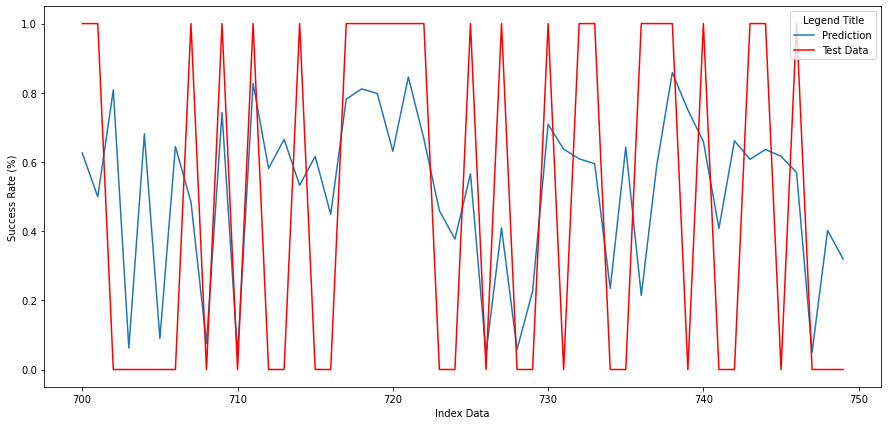

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
ax = plt.gca()
df_graph = df_plot[700:750]
df_graph.plot(kind='line',use_index=True,y='Predictions',ax=ax)
df_graph.plot(kind='line',use_index=True,y='Test Data', color='red', ax=ax)
ax.set_xlabel('Index Data')
ax.set_ylabel('Success Rate (%)')
plt.legend(['Prediction', 'Test Data'], loc='upper right', title='Legend Title')
plt.show()

In [37]:
y_test

,Test Data
0,0
1,1
2,1
3,1
4,1
...,...
13112,1
13113,0
13114,1
13115,0


In [38]:
Y_pred

,Predictions
0,0.246252
1,0.736949
2,0.602057
3,0.334953
4,0.759758
...,...
13112,0.654060
13113,0.886882
13114,0.813556
13115,0.077681


# Calculating the Performance Metric for XGBoost 

In [39]:
#https://stackoverflow.com/questions/35400372/using-f-score-in-xgb
def convert_to_y_bin(Y_pred, threshold=0.5): 
    y_bin = (Y_pred > threshold).astype(int) # works for both type(y) == <class 'numpy.ndarray'> and type(y) == <class 'pandas.core.series.Series'>
    return y_bin

In [40]:
y_bin = convert_to_y_bin(Y_pred)

In [41]:
y_bin

,Predictions
0,0
1,1
2,1
3,0
4,1
...,...
13112,1
13113,1
13114,1
13115,0


In [52]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
xgb_accuracy_score = accuracy_score(y_test, y_bin)
xgb_accuracy_f1score = f1_score(y_test,y_bin)
print("Model Accuracy: % f" % (xgb_accuracy_score))
print("Model F1-score: % f" % (xgb_accuracy_f1score))
precision_score(y_test, y_bin)
recall_score(y_test, y_bin)
print("Model Precision Score : ", msle)
print("Model Recall score : ", msle)
msle = mean_squared_log_error(Y_pred, y_test)
rmse = np.sqrt(mean_squared_error(Y_pred, y_test))
xgb_auc = roc_auc_score(y_test, Y_pred)
print("Mean Squared Logarithmic Error : ", msle)
print("Root Mean Squared Error : ", msle)
print("Model Compute Area Under the Receiver Operating Characteristic Curve : % f" %(xgb_auc))

Model Accuracy:  0.716856
Model F1-score:  0.719486
Model Precision Score :  0.09115741663697893
Model Recall score :  0.09115741663697893
Mean Squared Logarithmic Error :  0.09115741663697893
Root Mean Squared Error :  0.09115741663697893
Model Compute Area Under the Receiver Operating Characteristic Curve :  0.788670


In [44]:
from sklearn.metrics import confusion_matrix
def get_confusion_matrix_plot(y_test, y_predicted):
  cm = confusion_matrix(y_test, y_predicted)
  plt.figure(figsize=(15,10))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()

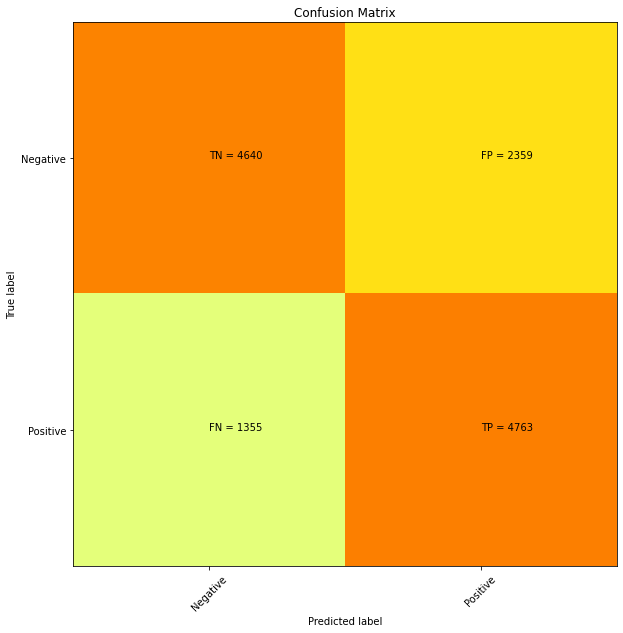

In [45]:
get_confusion_matrix_plot(y_test, y_bin)

# Deploy the Trained Model

In [47]:
xgb_predictor = xgb_estimator_attached.deploy(
	initial_instance_count=1,
	instance_type='ml.m4.xlarge',
	serializer=CSVSerializer)


-----!

In [48]:
#Get the test data to be predicted using the Sage Maker Endpoint
test_data = os.path.join(data_dir, 'test.csv')
X_test = pd.read_csv(test_data, header=None)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,10,10,5,1,1,1,1,0,0,66,45000,0
1,3,7,7,1,1,1,0,1,0,84,62000,0
2,10,10,7,0,1,1,1,0,0,70,72000,1
3,5,5,5,1,1,1,1,0,0,37,36000,0
4,2,10,10,1,1,1,0,1,0,41,52000,0


predictions in comma delimited string and need to be converted to a numpy array.

In [49]:
def predict_deployed_endpoint(data):
    """ Get predictions from the .csv file."""
    xgb_predictor.serializer = CSVSerializer()

    Y_pred = xgb_predictor.predict(data.values).decode('utf-8')
    
    predictions = np.fromstring(Y_pred, sep=',')
    return predictions

In [50]:
xgb_predictor

In [51]:
Y_pred = predict_deployed_endpoint(X_test)
Y_pred

array([0.2462523 , 0.73694867, 0.60205668, ..., 0.81355572, 0.07768082,
       0.2414017 ])

In [53]:
Y_pred_bin = convert_to_y_bin(Y_pred)

In [54]:
xgb_accuracy_score = accuracy_score(y_test, Y_pred_bin)
xgb_accuracy_f1score = (f1_score(y_test,Y_pred_bin))
print("Model Accuracy: % 3f" % (xgb_accuracy_score))
print("Model f1-score: % 3f" % (xgb_accuracy_f1score))


Model Accuracy:  0.716856
Model f1-score:  0.719486


In [55]:
xgb_msle = mean_squared_log_error(y_test,Y_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, Y_pred))
xgb_auc = roc_auc_score(y_test, Y_pred)
print("Model Mean Square Log Error : % f" %(xgb_msle))
print("Model Root Mean Square Error : % f" %(xgb_rmse))
print("Model Compute Area Under the Receiver Operating Characteristic Curve : % f" %(xgb_auc))

Model Mean Square Log Error :  0.091157
Model Root Mean Square Error :  0.430009
Model Compute Area Under the Receiver Operating Characteristic Curve :  0.788670


In [56]:
xgb_predictor.endpoint_name

'xgboost-2022-01-21-13-53-12-807'

### REMEMBER to delete the endpoint!

In [57]:
xgb_predictor.delete_endpoint()

# Final Results

Comparing all the performance using xtrain, ytrain

In [34]:
model_performance_results = []

classifier_type = ['XG Boost via SageMaker',
                   'Tuned XG Boost via SageMaker',
                   'Tuned Logistic Regression',
                   'Tuned Random Forest',
                   'Best Tuned Random Forest',
                   'Random Forest',
                   'Logistic Regression']
model_performance_results.append((0.714000, 0.715000))
model_performance_results.append((0.716856, 0.719486))
model_performance_results.append(get_model_performance_score(lr_randomized_search_cv.best_estimator_, X_train, y_train))
model_performance_results.append(get_model_performance_score(rf_randomized_search_cv.best_estimator_, X_train, y_train))
model_performance_results.append(get_model_performance_score(best_model.best_estimator_, X_train, y_train))
model_performance_results.append(get_model_performance_score(rf_initial_model, X_train, y_train))
model_performance_results.append(get_model_performance_score(lr_initial_model, X_train, y_train))

model_performance_results = pd.DataFrame(model_performance_results, columns=['accuracy', 'F1Score'])
classifier_type = pd.DataFrame(classifier_type, columns=['Classifier Type'])
model_performance_results = pd.concat([classifier_type, model_performance_results], axis=1)
model_performance_results = model_performance_results.sort_values('accuracy', ascending=False)
model_performance_results = model_performance_results.reset_index(drop=True)
model_performance_results



,Classifier Type,accuracy,F1Score
0,Best Tuned Random Forest,0.727504,0.736179
1,Tuned Random Forest,0.725496,0.734673
2,Tuned XG Boost via SageMaker,0.716856,0.719486
3,XG Boost via SageMaker,0.714000,0.715000
4,Logistic Regression,0.698991,0.698347
5,Random Forest,0.698915,0.720658
6,Tuned Logistic Regression,0.698254,0.694206


Comparing all the model performance using ytrain, ytest

In [35]:
model_performance_results = []

classifier_type = ['XG Boost via SageMaker',
                   'Tuned XG Boost via SageMaker',
                   'Tuned Logistic Regression',
                   'Tuned Random Forest',
                   'Best Tuned Random Forest',
                   'Random Forest',
                   'Logistic Regression']
model_performance_results.append((0.714000, 0.715000))
model_performance_results.append((0.716856, 0.719486))
model_performance_results.append(get_model_performance_score(lr_randomized_search_cv.best_estimator_, X_test, y_test))
model_performance_results.append(get_model_performance_score(rf_randomized_search_cv.best_estimator_, X_test, y_test))
model_performance_results.append(get_model_performance_score(best_model.best_estimator_, X_test, y_test))
model_performance_results.append(get_model_performance_score(rf_initial_model, X_test, y_test))
model_performance_results.append(get_model_performance_score(lr_initial_model, X_test, y_test))

model_performance_results = pd.DataFrame(model_performance_results, columns=['accuracy', 'F1Score'])
classifier_type = pd.DataFrame(classifier_type, columns=['Classifier Type'])
model_performance_results = pd.concat([classifier_type, model_performance_results], axis=1)
model_performance_results = model_performance_results.sort_values('accuracy', ascending=False)
model_performance_results = model_performance_results.reset_index(drop=True)
model_performance_results



,Classifier Type,accuracy,F1Score
0,Tuned XG Boost via SageMaker,0.716856,0.719486
1,XG Boost via SageMaker,0.714000,0.715000
2,Best Tuned Random Forest,0.708165,0.715221
3,Tuned Random Forest,0.707326,0.714890
4,Logistic Regression,0.704429,0.702342
5,Tuned Logistic Regression,0.700618,0.694611
6,Random Forest,0.696272,0.715550


In [45]:
parameter_performance_results_XGB = []
parameter_performance_results_XGB.append(('xgboost-220120-1408','xgboost-220121-1238-029-07256d0e','0.7824910283088684','30','0.035610065513557596','3.5','3', '8','5','712','0','0.7903352212645166','0.714000', '0.715000'))
parameter_performance_results_XGB.append(('xgboost-220121-1321','xgboost-220121-1321-029-2510f94e','0.7847660183906555','30','2.927982866805479', '2.927982866805479','3', '8','3','730','0','0.7979210498324821', '0.716856', '0.719486'))
parameter_performance_results_XGB = pd.DataFrame(parameter_performance_results_XGB, columns=['tuner name','best-training-job','auc','early_stopping_rounds', 'eta', 'gamma','max_delta_step','max_depth','min_child_weight','num_round','silent','subsample','accuracy score', 'F1 Score'])
parameter_performance_results_XGB
parameter_performance_results_XGB.transpose()

,0,1
tuner name,xgboost-220120-1408,xgboost-220121-1321
best-training-job,xgboost-220121-1238-029-07256d0e,xgboost-220121-1321-029-2510f94e
auc,0.7824910283088684,0.7847660183906555
early_stopping_rounds,30,30
eta,0.035610065513557596,2.927982866805479
gamma,3.5,2.927982866805479
max_delta_step,3,3
max_depth,8,8
min_child_weight,5,3
num_round,712,730


# Conclusion

References

* https://www.udacity.com/course/aws-machine-learning-engineer-nanodegree--nd189
* https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
* https://machinelearningmastery.com/calculate-feature-importance-with-python/
* https://www.youtube.com/watch?v=Q5dH5mOQ_ik
* https://github.com/udacity/sagemaker-deployment/blob/master/Tutorials/Boston%20Housing%20-%20XGBoost%20(Batch%20Transform)%20-%20High%20Level.ipynb
* https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html

In [ ]:
# Convert the notebook into a html file
!!jupyter nbconvert *.ipynb